## Data Import

In [548]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import  Counter
import seaborn as sns
from sklearn.utils import shuffle

from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import re
from spellchecker import SpellChecker
from wordcloud import WordCloud

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [5]:
print('Trainning Set Shape={}'.format(train.shape))
print('Trainning Set Memory Usage={:.2f} MB'.format(train.memory_usage().sum()/1024**2))
print('Trainning Set Shape={}'.format(test.shape))
print('Trainning Set Memory Usage={:.2f} MB'.format(test.memory_usage().sum()/1024**2))

Trainning Set Shape=(7613, 5)
Trainning Set Memory Usage=0.29 MB
Trainning Set Shape=(3263, 4)
Trainning Set Memory Usage=0.10 MB


## Accuracy check

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
train.shape

(7613, 5)

In [8]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [9]:
train.isnull().sum() * 100 / len(train)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [10]:
test.isnull().sum() * 100 / len(test)

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

In [11]:
print('The unique values in Training location column: {}'.format(train['location'].unique().shape[0]))
print('The unique values in Testing location column: {}'.format(test['location'].unique().shape[0]))
print('The unique values in Training keyword column: {}'.format(train['keyword'].unique().shape[0]))
print('The unique values in Testing keywords column: {}'.format(test['keyword'].unique().shape[0]))

The unique values in Training location column: 3342
The unique values in Testing location column: 1603
The unique values in Training keyword column: 222
The unique values in Testing keywords column: 222


In [12]:
train[train['target']==1].groupby('keyword').count().sort_values(['id'],ascending=False)

,id,location,text,target
keyword,,,,
derailment,39,25,39,39
wreckage,39,28,39,39
outbreak,39,30,39,39
debris,37,22,37,37
oil%20spill,37,27,37,37
...,...,...,...,...
blazing,1,1,1,1
epicentre,1,1,1,1
body%20bag,1,1,1,1


In [13]:
train[train['target']==0].groupby('keyword').count().sort_values(['id'],ascending=False)

,id,location,text,target
keyword,,,,
body%20bags,40,22,40,40
harm,37,26,37,37
armageddon,37,28,37,37
wrecked,36,20,36,36
ruin,36,27,36,36
...,...,...,...,...
typhoon,1,1,1,1
suicide%20bombing,1,0,1,1
suicide%20bomber,1,0,1,1


## Meta Features

### Word_count 

In [14]:
train[train['target']==1]['text'].apply(lambda x:len(str(x).split())) 

0       13
1        7
2       22
3        8
4       16
        ..
7608    11
7609    20
7610     8
7611    19
7612    13
Name: text, Length: 3271, dtype: int64

In [15]:
train[train['target']==0]['text'].apply(lambda x:len(str(x).split()))

15       3
16       3
17       3
18       5
19       3
        ..
7581    13
7582    11
7584    13
7587     2
7593    12
Name: text, Length: 4342, dtype: int64

In [16]:
train.shape

(7613, 5)

In [17]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [19]:
len(train['keyword'].unique())

222

## Checking Not Null values of keword 

In [20]:
train.loc[train['keyword'].notnull(), ['keyword','target']]

,keyword,target
31,ablaze,1
32,ablaze,0
33,ablaze,1
34,ablaze,0
35,ablaze,0
...,...,...
7578,wrecked,0
7579,wrecked,0
7580,wrecked,0
7581,wrecked,0


In [21]:
train[train['keyword'] == 'wrecked']

,id,keyword,location,text,target
7544,10785,wrecked,"Brooklyn, NY",Wrecked an hour on YouTube with @julian_lage @...,0
7545,10786,wrecked,Robin Hood's County,late night mcdonalds with friends = hilarious ...,0
7546,10787,wrecked,NaN,good luck to everyone who has school soon but ...,0
7547,10788,wrecked,United States,I wonder how times someone has wrecked trying ...,0
7548,10789,wrecked,Pennsylvania,Four hundred wrecked cars (costing $100 apiece...,0
7549,10790,wrecked,NaN,Cramer: IgerÛªs 3 words that wrecked DisneyÛ...,0
7550,10793,wrecked,NaN,Poor Liv and I getting our phones wrecked on t...,0
7551,10794,wrecked,NaN,On the freeway to Africa til I wrecked my Audi,0
7552,10795,wrecked,"Santa Cruz, CA",Israel wrecked my home. Now it wants my land. ...,1
7553,10798,wrecked,NaN,#news Cramer: Iger's 3 words that wrecked Disn...,0


## Text Cleaning
### This dataset requires a lot of cleaning. 
#### Have to remove Punctuations, Urls, Special Characters, stoping words etc.

In [22]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Distribution

Text(0, 0.5, 'samples')

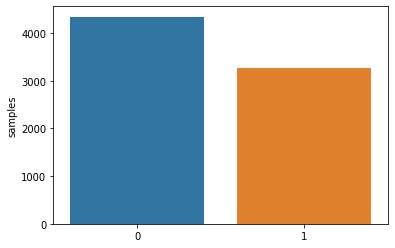

In [23]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

## Creating corpus 

In [24]:
def create_corpus(target):
    corpus=[]
    
    for doc in train[train['target']==target]['text'].str.split():
        for word in doc:
            word = word.lower()
            corpus.append(word)
    return corpus

### Let's look at commong stopwords and their frequencies

In [25]:
stop=set(stopwords.words('english'))

In [26]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

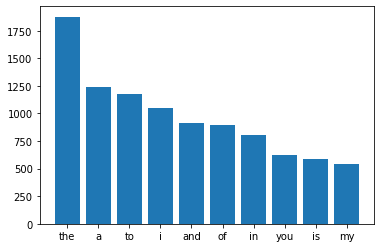

In [27]:
x,y=zip(*top)
plt.bar(x,y)

In [28]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

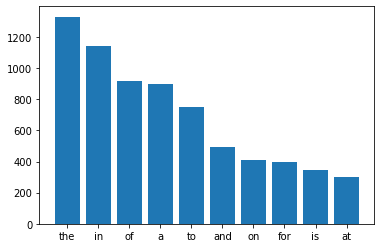

In [29]:
x,y=zip(*top)
plt.bar(x,y)

### Punctuations

#### Class 1

<BarContainer object of 18 artists>

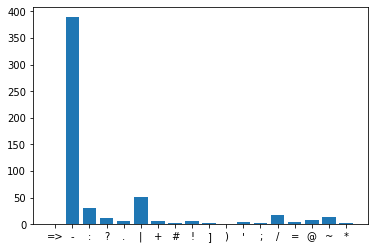

In [30]:
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

#### Class 0

<BarContainer object of 20 artists>

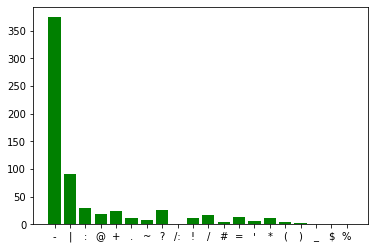

In [31]:
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

## Most Common words

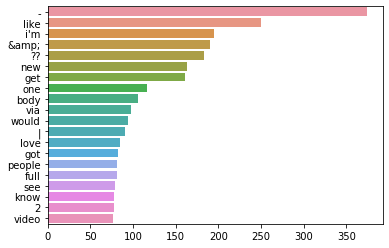

In [32]:
#Top 20 Common words
corpus=create_corpus(0)
start = 0
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:]:
    if start == 20:
        break
    if (word not in stop) :
        start += 1
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

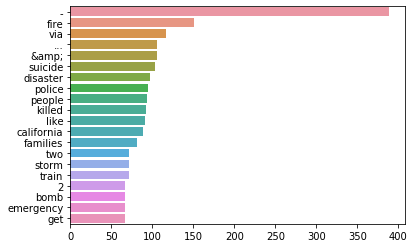

In [33]:
corpus=create_corpus(1)
start = 0
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:]:
    if start == 20:
        break
    if (word not in stop) :
        start += 1
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

### We can see that there are a lot of punctuations and unnecessary words. 

## Data Cleaning

In [290]:
tweet = pd.concat([train, test], sort=False)
tweet.shape

(10876, 5)

In [291]:
#Removing URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

#Remove Html Tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

#Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

#Removing stoping words
def remove_stopwords(text):
    text = text.lower()
    text_tokens = nltk.tokenize.word_tokenize(text)
    token = [word for word in text_tokens if not word in stop]
    token = ' '.join(token)
    return token

In [292]:
tweet['text']=tweet['text'].apply(lambda x : remove_URL(x))
tweet['text']=tweet['text'].apply(lambda x : remove_html(x))
tweet['text']=tweet['text'].apply(lambda x : remove_emoji(x))
tweet['text']=tweet['text'].apply(lambda x : remove_punct(x))
tweet['text']=tweet['text'].apply(lambda x: remove_stopwords(x))

In [257]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,residents asked shelter place notified officer...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1.0


In [620]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Let's see data

In [293]:
text  = " ".join(tweet['text'][:7613])

In [294]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [295]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).generate(text)

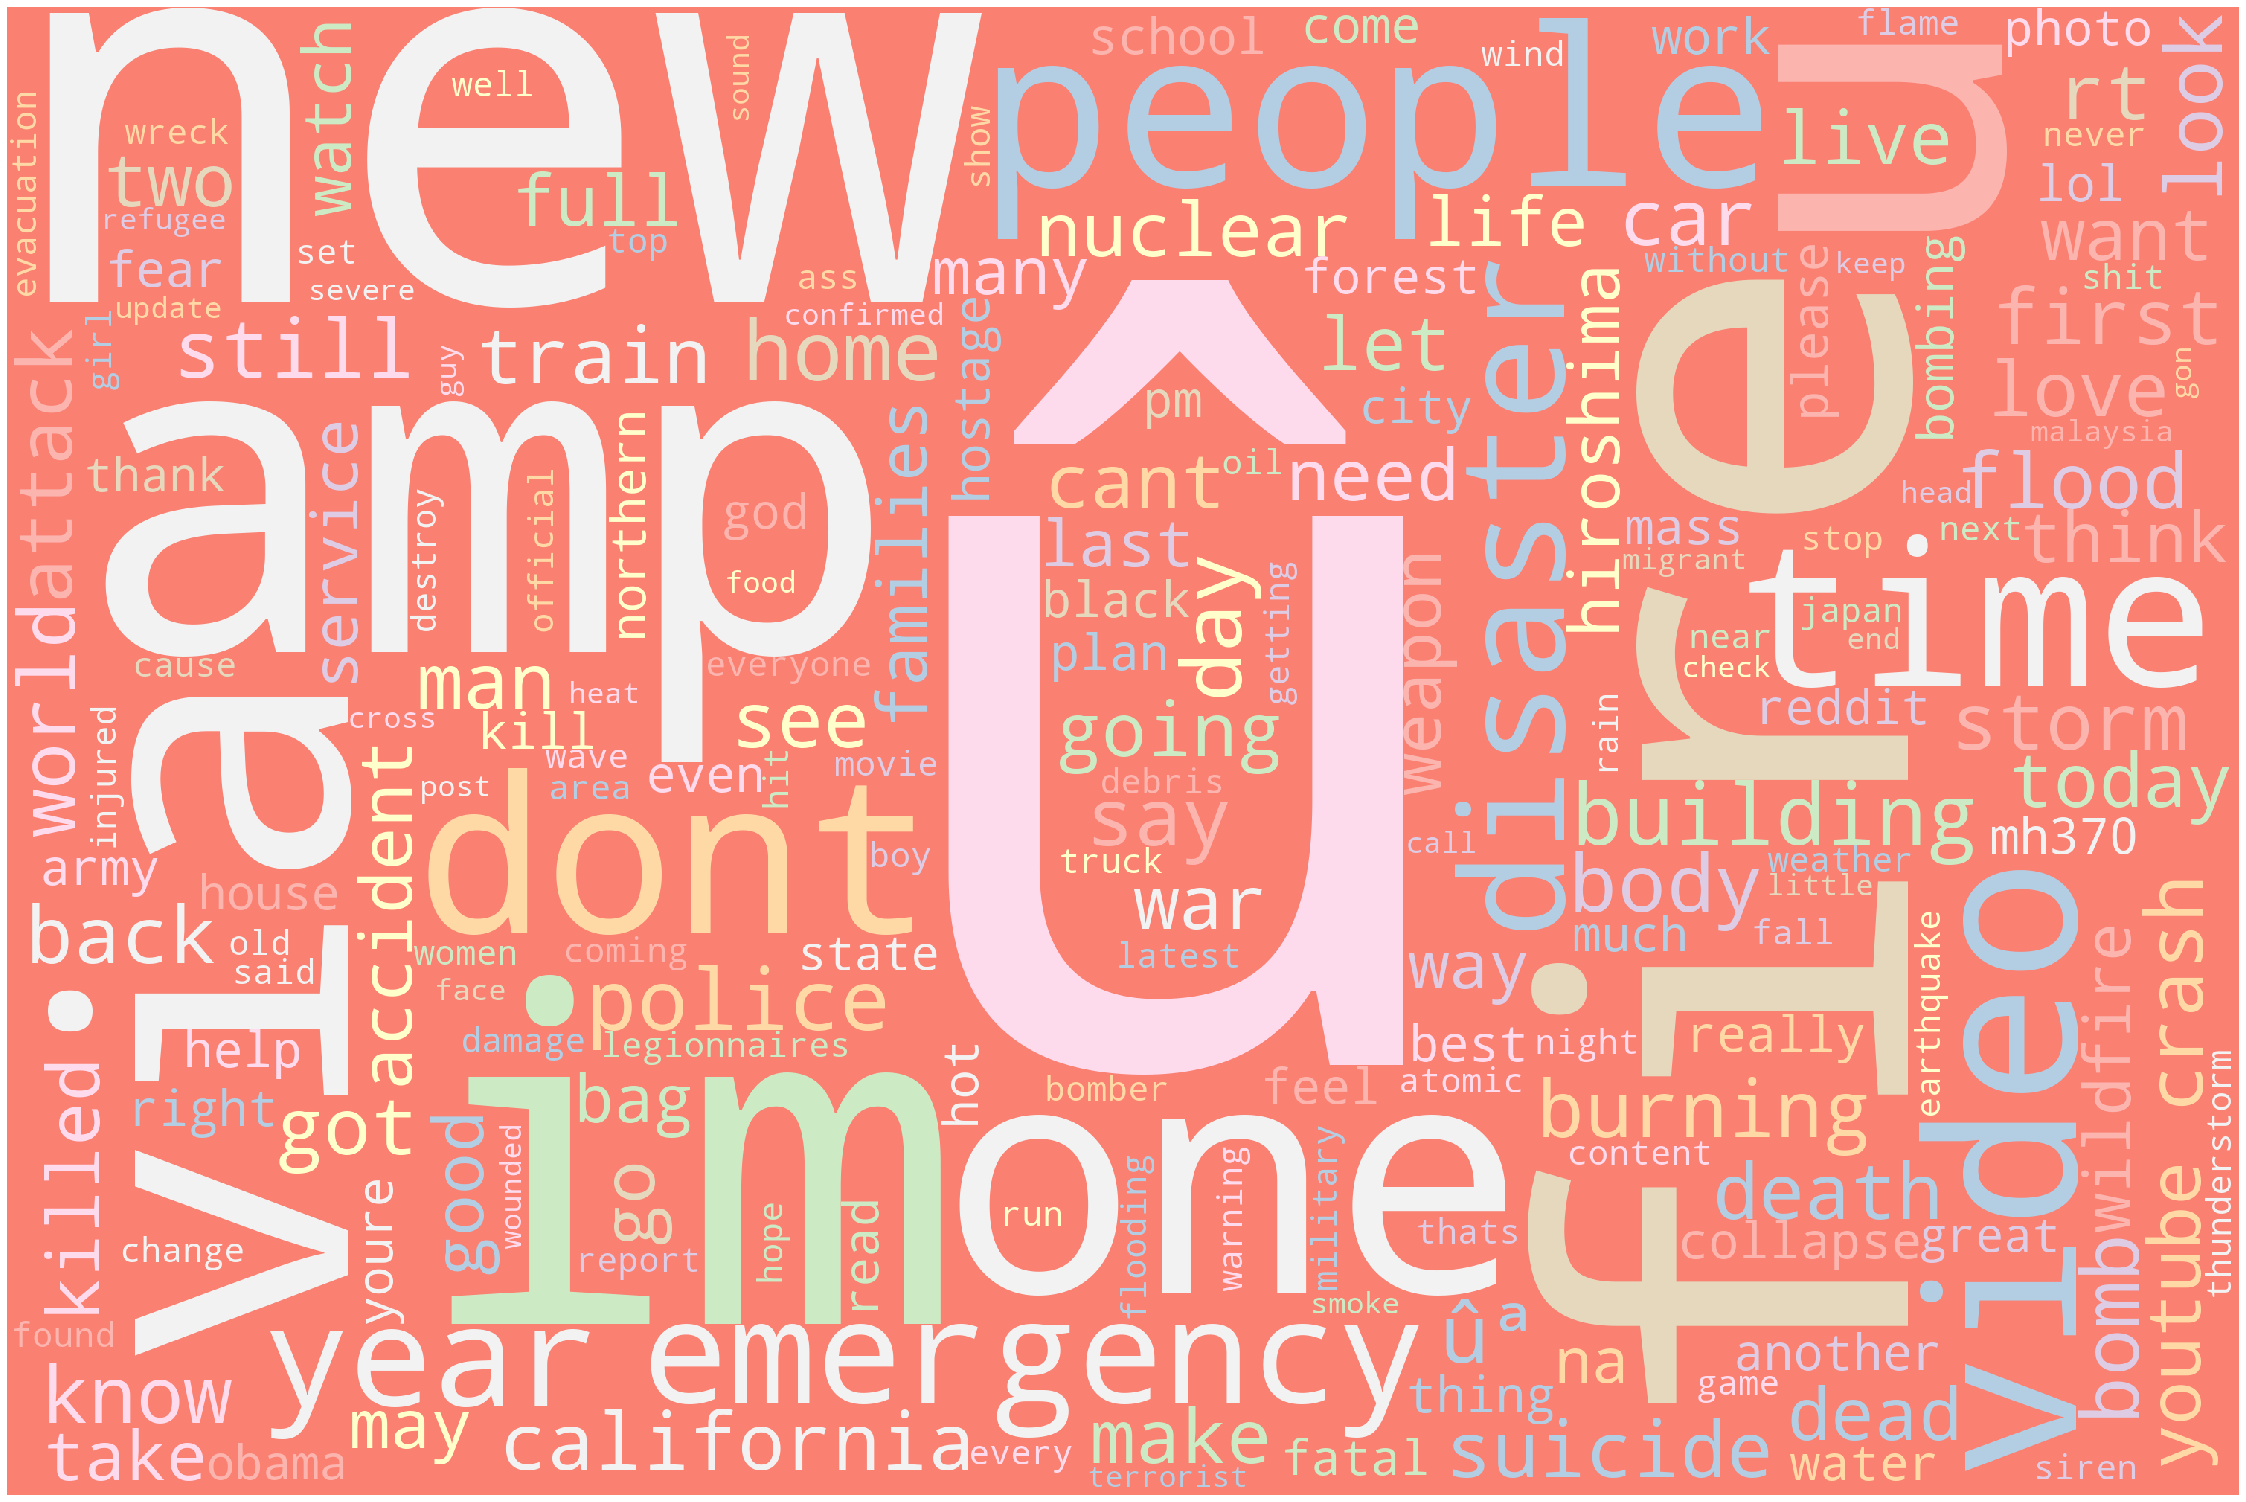

In [296]:
plot_cloud(wordcloud)

In [297]:
tweet.iloc[0:7613]['target'].isnull().sum()

0

In [298]:
tweet.iloc[7613:]['target'].isnull().sum()

3263

In [299]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,residents asked shelter place notified officer...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1.0


## Word Frequency Map

In [349]:
current_index = 0
word_index_map = {}

In [625]:
len(word_index_map)

22671

In [350]:
def wordIndexMap(text, current_index):
    tokens = nltk.tokenize.word_tokenize(text)
    for token in tokens:
        if token not in word_index_map:
            word_index_map[token] = current_index
            current_index += 1
    return current_index

In [351]:
text_list = tweet['text'].tolist()
for each_text in text_list:
    current_index = wordIndexMap(each_text, current_index)

In [621]:
word_index_map

{'deeds': 0,
 'reason': 1,
 'earthquake': 2,
 'may': 3,
 'allah': 4,
 'forgive': 5,
 'us': 6,
 'forest': 7,
 'fire': 8,
 'near': 9,
 'la': 10,
 'ronge': 11,
 'sask': 12,
 'canada': 13,
 'residents': 14,
 'asked': 15,
 'shelter': 16,
 'place': 17,
 'notified': 18,
 'officers': 19,
 'evacuation': 20,
 'orders': 21,
 'expected': 22,
 '13000': 23,
 'people': 24,
 'receive': 25,
 'wildfires': 26,
 'california': 27,
 'got': 28,
 'sent': 29,
 'photo': 30,
 'ruby': 31,
 'alaska': 32,
 'smoke': 33,
 'pours': 34,
 'school': 35,
 'rockyfire': 36,
 'update': 37,
 'hwy': 38,
 '20': 39,
 'closed': 40,
 'directions': 41,
 'due': 42,
 'lake': 43,
 'county': 44,
 'cafire': 45,
 'flood': 46,
 'disaster': 47,
 'heavy': 48,
 'rain': 49,
 'causes': 50,
 'flash': 51,
 'flooding': 52,
 'streets': 53,
 'manitou': 54,
 'colorado': 55,
 'springs': 56,
 'areas': 57,
 'im': 58,
 'top': 59,
 'hill': 60,
 'see': 61,
 'woods': 62,
 'theres': 63,
 'emergency': 64,
 'happening': 65,
 'building': 66,
 'across': 67,
 's

In [355]:
length_of_unique_words = len(word_index_map)

## Converting words to vector

### Convert Text to tokens

In [358]:
def to_tokens(text):
    text_tokens = nltk.tokenize.word_tokenize(text)
    return text_tokens

In [622]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [359]:
tweet['text']=tweet['text'].apply(lambda x: to_tokens(x))

In [360]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1.0
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1.0
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1.0
3,6,NaN,NaN,"[13000, people, receive, wildfires, evacuation...",1.0
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1.0


In [435]:
def words_to_vector(tokens, i):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    x = x / x.sum()
    return x

In [623]:
2/5

0.4

In [436]:
data = np.zeros((len(tweet), len(word_index_map)))

In [624]:
data

array([[0.14285714, 0.14285714, 0.14285714, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [611]:
data.shape

(10876, 22671)

In [437]:
for i in range(0, len(tweet)):
    data[i,:] = words_to_vector(tweet.iloc[i]['text'], i)

/Users/iamgrewal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [521]:
Xtrain = data[:7613,]

In [610]:
len(Xtrain[0])

22671

In [538]:
Xtest = data[7613:,]

In [523]:
Ytrain = np.array(tweet.iloc[:7613]['target'])

In [549]:
model = LogisticRegression()
model.fit(Xtrain, Ytrain)
print("Train accuracy:", model.score(Xtrain, Ytrain))

Train accuracy: 0.7802443189281493


In [539]:
submission_label = pd.read_csv('./submission.csv')

In [541]:
Ytest = np.array(submission_label.iloc[:]['target'])

### Removing NA row from test set

In [543]:
Xtest = np.delete(Xtest, 13, 0)
Ytest = np.delete(Ytest, 13, 0)

## Prediction Score

In [547]:
print("Test accuracy:", model.score(Xtest, Ytest))

Test accuracy: 0.8010423053341508


In [618]:
threshold = 1
for word, index in iteritems(word_index_map):
    weight = model.coef_[0][index]
    if abs(weight) > threshold:
        print(word, weight)

earthquake 1.9487075856077527
forest 1.4784215025257146
fire 3.1111112130481127
near 1.6619180706824603
evacuation 1.5047355199734356
california 3.5969674686412856
got -1.381580872825698
smoke -1.1579766500208515
county 1.0415964586670696
flood 1.1444202330884563
disaster 2.3929623192579186
flooding 1.4017188966365708
im -3.5816666440829006
see -1.3106182667614816
tornado 1.0534876426718756
area 1.2131917533681682
heat 1.054542413217661
car 1.257186843825592
crash 1.8402631706187076
love -2.4871532103403364
day -1.1432210748689096
cant -1.602483878303452
like -2.238322592671227
night -1.006370148894029
much -1.1652269254882928
new -2.3162954584617275
two 1.6400089822872685
police 2.6199236038875715
youre -1.3719394490727996
dead 1.158154447600596
time -1.3739348698088627
know -1.3027354888116138
get -1.4782305765599124
years 1.0743832733530911
city 1.1344355179211756
would -1.5314728659126737
amp -1.230275687731371
fires 3.030829809696539
nowplaying -1.1758079206916663
dont -1.67960352

In [617]:
len(model.coef_[0])

22671